# Spotify Global Music Dataset

## 1. Installind & Importing Required Libraries

We first install and then import the libraries needed for data manipulation, visualization, and dataset downloading.

```pip install numpy```  
```pip install pandas```  
```pip install seaborn```  
```pip install matplotlib```  

```pip install kagglehub```  
```pip install kagglehub[pandas-datasets]```

In [183]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [184]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

## 2. Setting File Path

We specify the name of the data file in order to import it.

In [185]:
file_path = "track_data_final.csv"

## 3. Loading the dataset

### 3.1. Loading the Dataset with KaggleHub

We try to use KaggleHub, which directly gets the data from the online dataset _(code obtained from the Kaggle website)_.

In [186]:
# Load the latest version
df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "wardabilal/spotify-global-music-dataset-20092025",
  file_path,
  # Provide any additional arguments like 
  # sql_query or pandas_kwargs. See the 
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

### 3.2. Loading the CSV Locally

If the KaggleHub import doesn't work, we can also import the dataset from a local CSV file.

In [187]:
df = pd.read_csv(f"./data/{file_path}")

## 4. Cleaning the Data

We need to remove any unnecessary columns that don't provide any value to our analysis. For instance, the track number or the album it belongs won't give us any insight on how well the song performs (the album will benefit from the track, not in the other way). We'll also remove the album total tracks, the artist genre (half of the artists don't have any) and the track name and id.
<br>
We'll keep the date, as it gives us a chronological indicator.

In [188]:
# Dropping columns that do not contribute to song performance analysis
df = df.drop("track_number", axis=1)
df = df.drop("track_name", axis=1)
df = df.drop("track_id", axis=1)
df = df.drop("artist_genres", axis=1)
df = df.drop("album_id", axis=1)
df = df.drop("album_name", axis=1)
df = df.drop("album_total_tracks", axis=1)

### 4.1 Checking for Missing Values

In [189]:
# Checking for missing values
df.isnull().sum()

track_popularity      0
track_duration_ms     0
explicit              0
artist_name           4
artist_popularity     4
artist_followers      4
album_release_date    0
album_type            0
dtype: int64

### 4.2 Handling Missing Artist Information

Some rows may have missing artist names or popularity metrics. <br>
Artist names and release dates are replaced by ```"unknown"``` when missing.

In [190]:
# Identify missing artist names
missing_artist_name = [
    [index, row] for index, row in df.iterrows() 
    if pd.isna(row["artist_name"])
]
print(missing_artist_name)

[[436, track_popularity              65
track_duration_ms         214586
explicit                    True
artist_name                  NaN
artist_popularity            NaN
artist_followers             NaN
album_release_date    2012-01-01
album_type                 album
Name: 436, dtype: object], [1396, track_popularity              68
track_duration_ms         160166
explicit                   False
artist_name                  NaN
artist_popularity            NaN
artist_followers             NaN
album_release_date    2023-04-07
album_type                single
Name: 1396, dtype: object], [3885, track_popularity              30
track_duration_ms         255634
explicit                   False
artist_name                  NaN
artist_popularity            NaN
artist_followers             NaN
album_release_date    2011-04-18
album_type                single
Name: 3885, dtype: object], [3886, track_popularity              59
track_duration_ms         247533
explicit                   Fals

In [191]:
# Filling missing numerical fields with their most common value
mode_artist_popularity = df["artist_popularity"].mode()[0]
df["artist_popularity"] = df["artist_popularity"].fillna(mode_artist_popularity)

mode_artist_followers = df["artist_followers"].mode()[0]
df["artist_followers"] = df["artist_followers"].fillna(mode_artist_followers)

# Replace missing string fields
df["artist_name"] = df["artist_name"].fillna("unknown")
df["album_release_date"] = df["album_release_date"].fillna("unknown")

### 4.3 Converting In Numeric Format

We need to convert artist names, album types, and explicit content to numerical categories.

In [192]:
# Change the strings to unique identifiers
print(df["album_type"].unique())
print(df["artist_name"].unique())

['compilation' 'single' 'album']
['Britney Spears' 'BUNT.' 'Taylor Swift' ... 'Troy' 'Zelda' 'bôa']


In [193]:
# Mapping artist names into unique identifiers
conversion_artist = {}
unique_id = 0

for artist in df["artist_name"]:
    if artist not in conversion_artist:
        conversion_artist[artist] = unique_id
        unique_id += 1

df["artist_name"] = df["artist_name"].map(conversion_artist)

In [194]:
# Mapping album_type
df["album_type"] = df["album_type"].map({"compilation": 0, "single": 1, "album": 2})

In [195]:
# Mapping explicit
df["explicit"] = df["explicit"].map({False: 0, True: 1})

### 4.4. Decomposing date

We split the date into **year**, **month**, and **day**, and the original date column is removed.

In [196]:
# Initialize year/month/day columns
df["year"] = [None] * len(df)
df["month"] = [None] * len(df)
df["day"] = [None] * len(df)

date_order = ["year", "month", "day"]

In [197]:
for index, row in df.iterrows():
    date_parts = row["album_release_date"].split("-")

    for i in range(3 - len(date_parts)):                # Other way : date_parts.extend([0] * (3 - len(date_parts)))
        date_parts.append(0)

    for i in range(3):
        df.loc[index, date_order[i]] = date_parts[i]

df = df.drop("album_release_date", axis=1)

______________________________________________________________________________________________________________________________________________________

## 5. Visualizing the data
1. &#x2611; Histograms
    1. Track Popularity
    2. Track Duration (ms)
    3. Artist Popularity
2. &#x2610; Boxplots for outliers
3. &#x2611; Bar graphs
    1. Number of tracks released per year
    2. Average track popularity per album type
4. &#x2611; Scatter plots
    1. Track popularity vs. artist popularity
    2. Track popularity vs. artist followers
    3. Track popularity vs. duration
    4. Track popularity vs. release year
5. &#x2611; Pie chart
    1. Percentage of explicit lyrics
    2. Distribution of album types
6. &#x2611; Correlation Heatmap

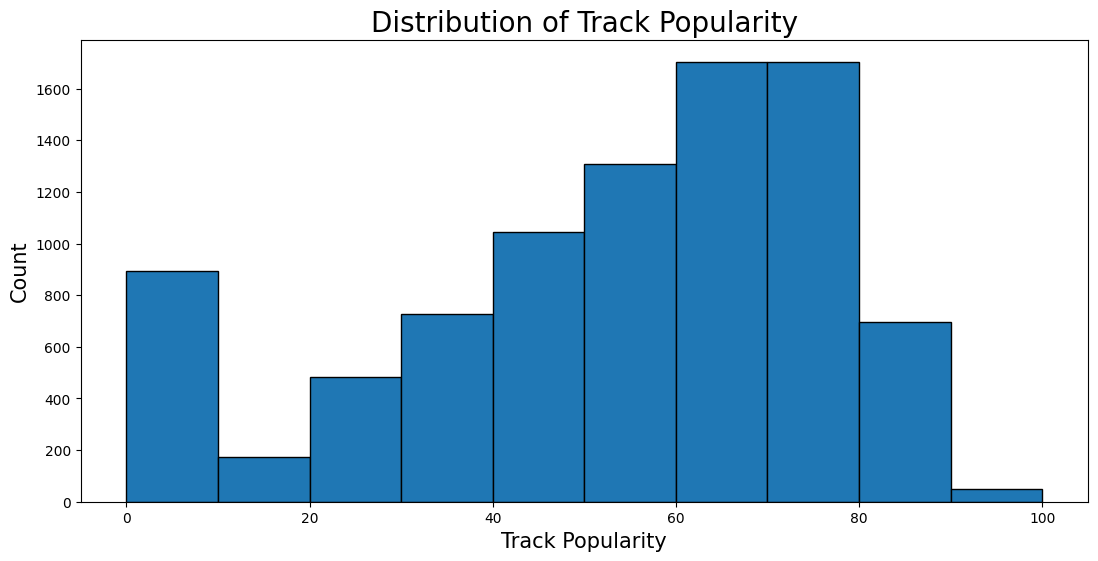

In [198]:
# Histogram of track popularity
plt.figure(figsize=(13, 6))
plt.hist(df.track_popularity, edgecolor='black')
plt.xlabel("Track Popularity", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.title("Distribution of Track Popularity", fontsize=20)
plt.show()

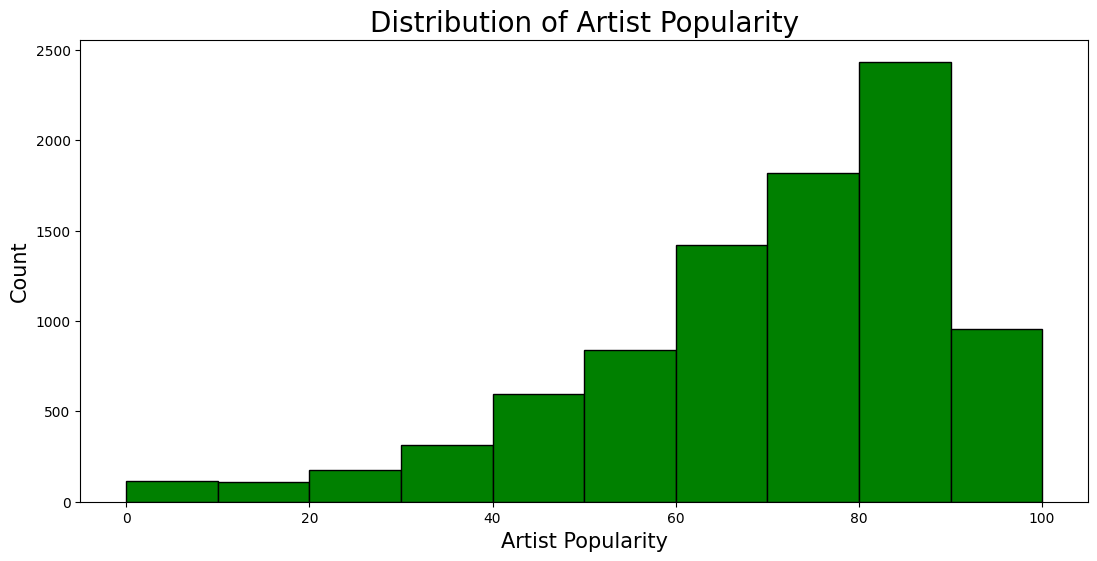

In [199]:
# Histogram of artist followers
plt.figure(figsize=(13, 6))
plt.hist(df.artist_popularity, edgecolor='black', color='green')
plt.xlabel("Artist Popularity", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.title("Distribution of Artist Popularity", fontsize=20)
plt.show()

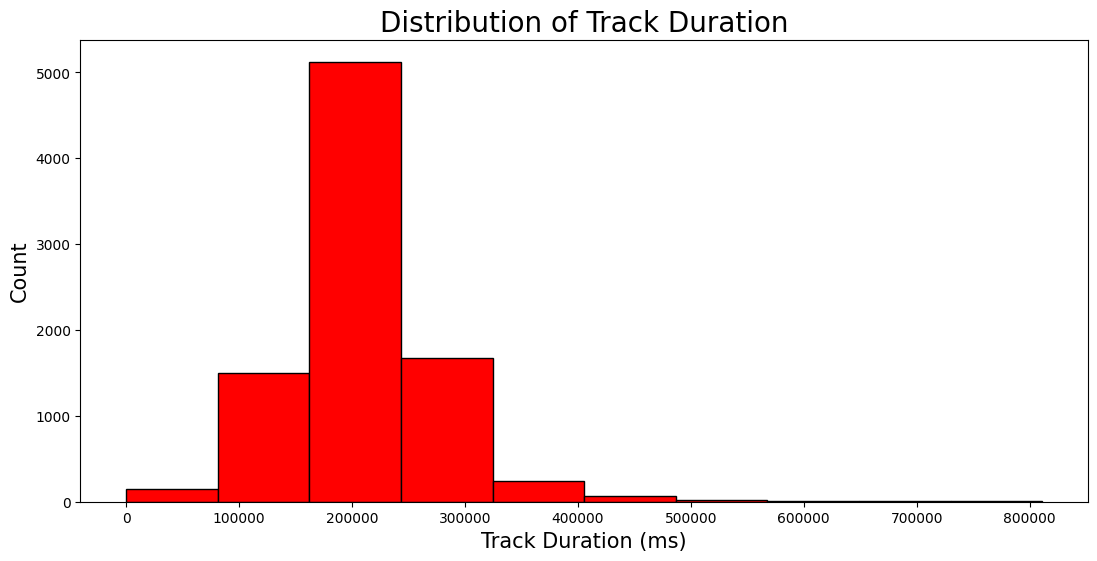

In [200]:
# Histogram of track duration
plt.figure(figsize=(13, 6))
plt.hist(df.track_duration_ms, edgecolor='black', color='red')
plt.xlabel("Track Duration (ms)", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.title("Distribution of Track Duration", fontsize=20)
plt.show()

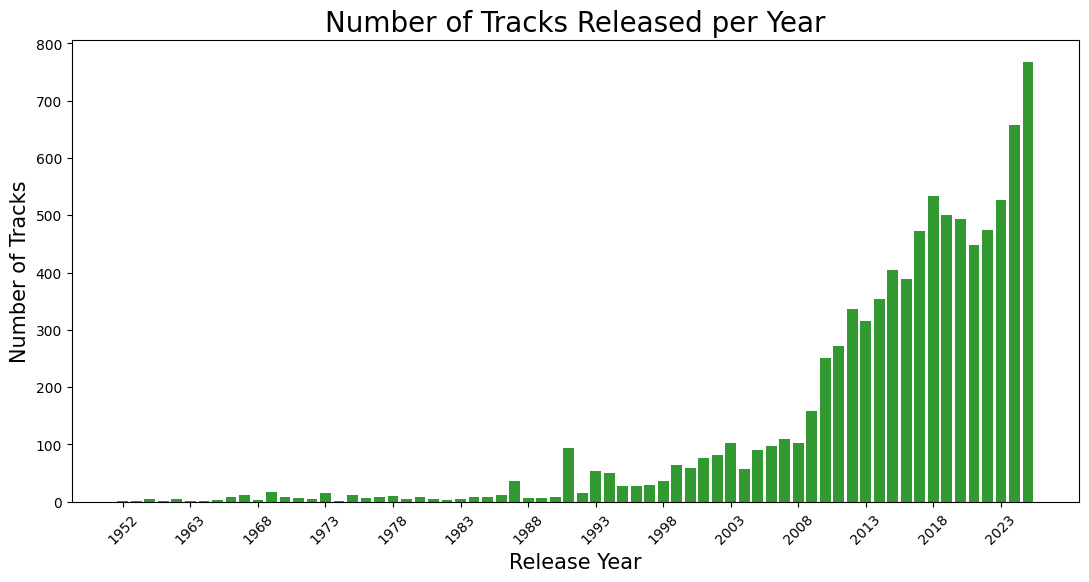

In [201]:
# Bar chart of number of tracks released per year
plt.figure(figsize=(13, 6))
tracks_per_year = df.year.value_counts().sort_index()[1:] # Exclude year 0
plt.bar(tracks_per_year.index, tracks_per_year.values, color='green', alpha=0.8)
plt.xticks(tracks_per_year.index[::5], rotation=45)
plt.xlabel("Release Year", fontsize=15)
plt.ylabel("Number of Tracks", fontsize=15)
plt.title("Number of Tracks Released per Year", fontsize=20)
plt.show()

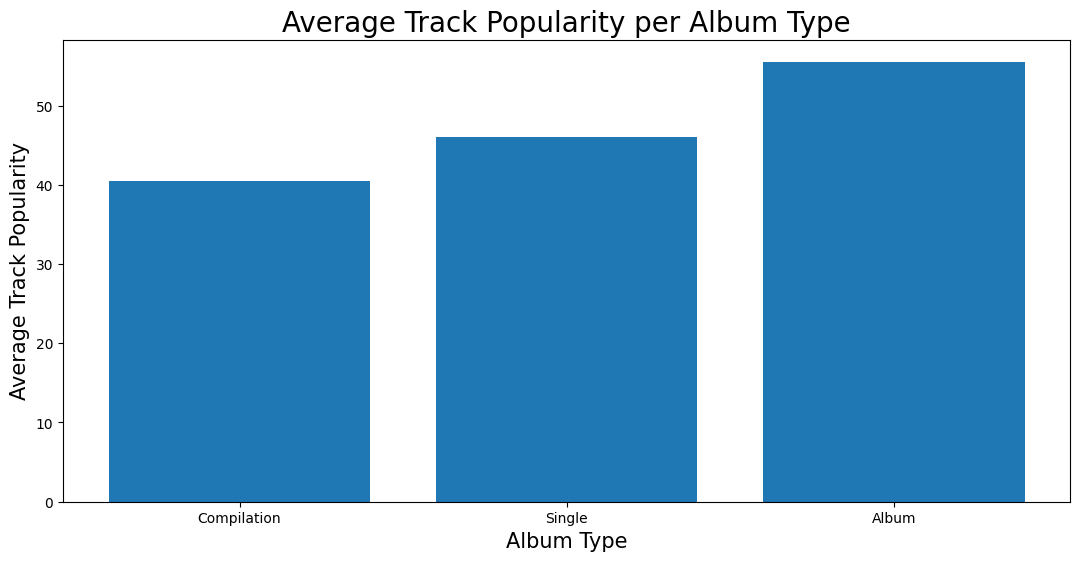

In [202]:
# Bar chart of average track popularity per album type
plt.figure(figsize=(13, 6))
avg_popularity_per_album_type = df.groupby("album_type").track_popularity.mean()
plt.bar(avg_popularity_per_album_type.index, avg_popularity_per_album_type.values)
plt.xticks(avg_popularity_per_album_type.index, ['Compilation', 'Single', 'Album'])
plt.xlabel("Album Type", fontsize=15)
plt.ylabel("Average Track Popularity", fontsize=15)
plt.title("Average Track Popularity per Album Type", fontsize=20)
plt.show()

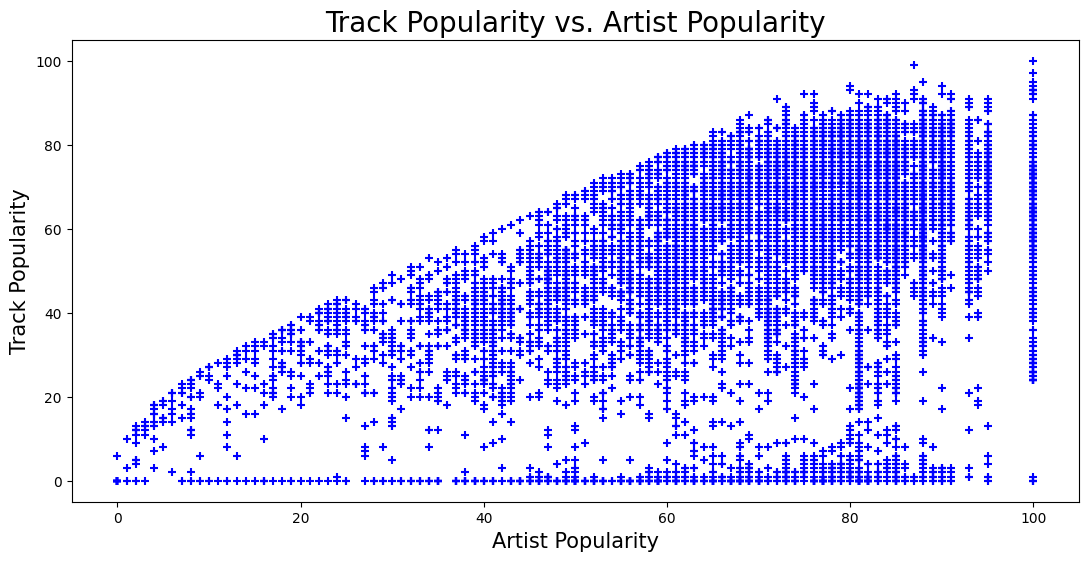

In [203]:
# Scatter plot of track popularity vs. artist popularity
plt.figure(figsize=(13, 6))
plt.scatter(df.artist_popularity, df.track_popularity, color='blue', marker='+')
plt.xlabel("Artist Popularity", fontsize=15)
plt.ylabel("Track Popularity", fontsize=15)
plt.title("Track Popularity vs. Artist Popularity", fontsize=20)
plt.show()

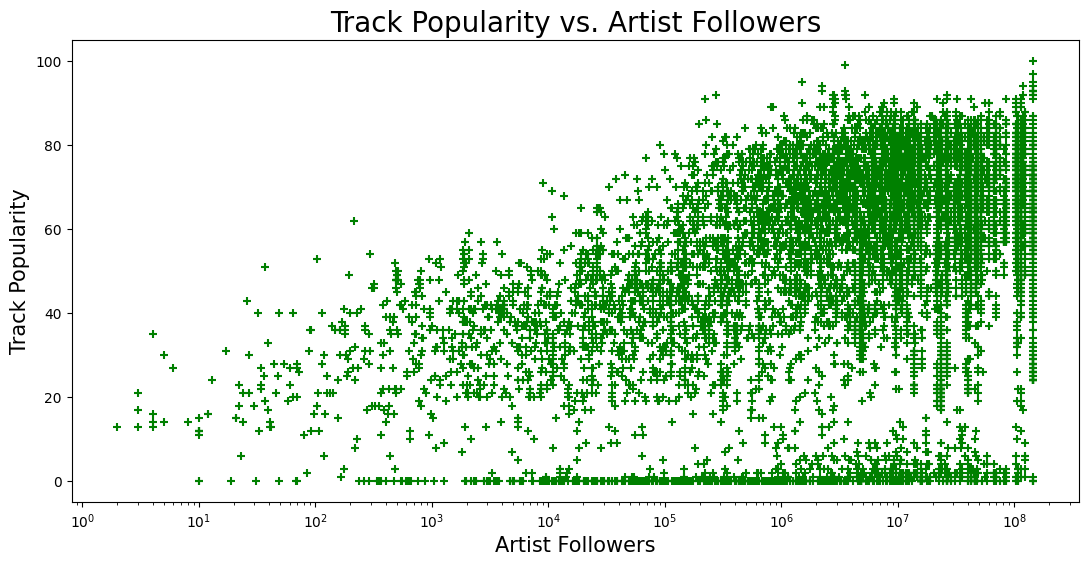

In [204]:
# Scatter plot of track popularity vs. artist followers
plt.figure(figsize=(13, 6))
plt.scatter(df.artist_followers, df.track_popularity, color='green', marker='+')
plt.xscale('log')
plt.xlabel("Artist Followers", fontsize=15)
plt.ylabel("Track Popularity", fontsize=15)
plt.title("Track Popularity vs. Artist Followers", fontsize=20)
plt.show()

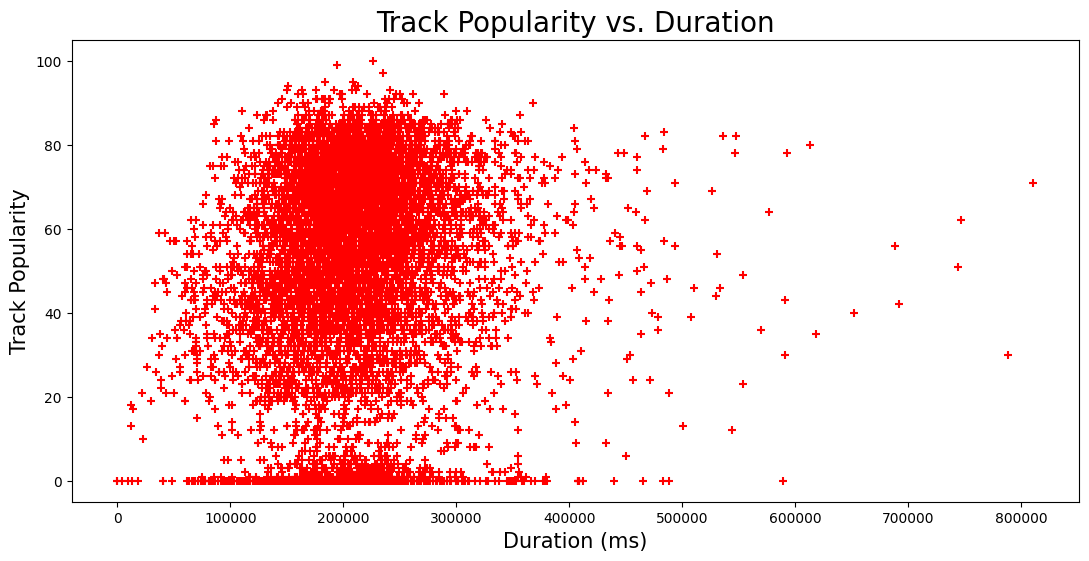

In [205]:
# Scatter plot of track popularity vs. duration
plt.figure(figsize=(13, 6))
plt.scatter(df.track_duration_ms, df.track_popularity, color='red', marker='+')
plt.xlabel("Duration (ms)", fontsize=15)
plt.ylabel("Track Popularity", fontsize=15)
plt.title("Track Popularity vs. Duration", fontsize=20)
plt.show()

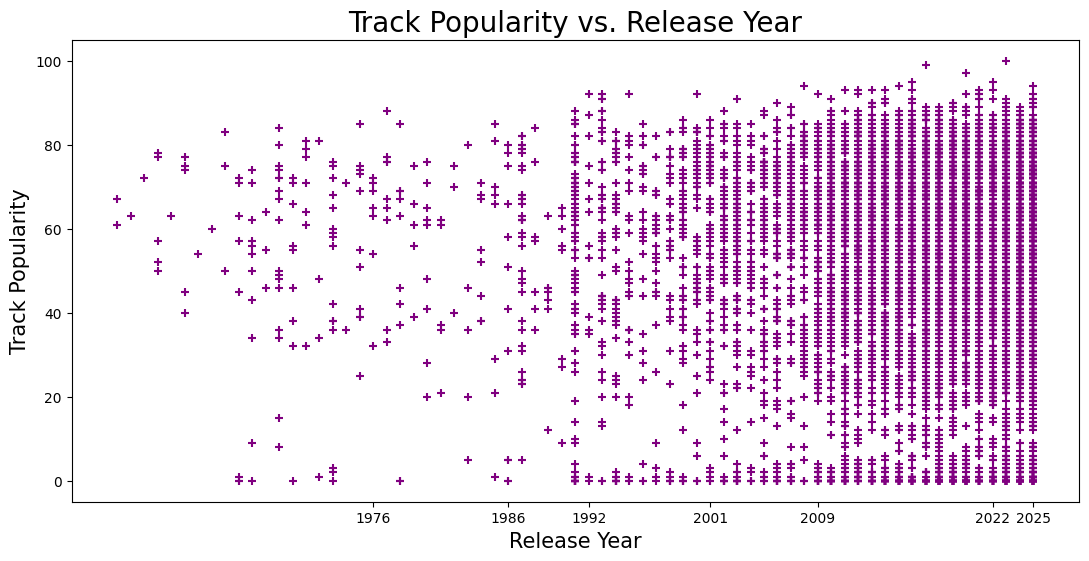

In [206]:
# Scatter plot of track popularity vs. release year
plt.figure(figsize=(13, 6))
plt.scatter(sorted(df.year), df.track_popularity, color='purple', marker='+')
plt.xticks(df.year.unique()[::10])
plt.xlabel("Release Year", fontsize=15)
plt.ylabel("Track Popularity", fontsize=15)
plt.title("Track Popularity vs. Release Year", fontsize=20)
plt.show()

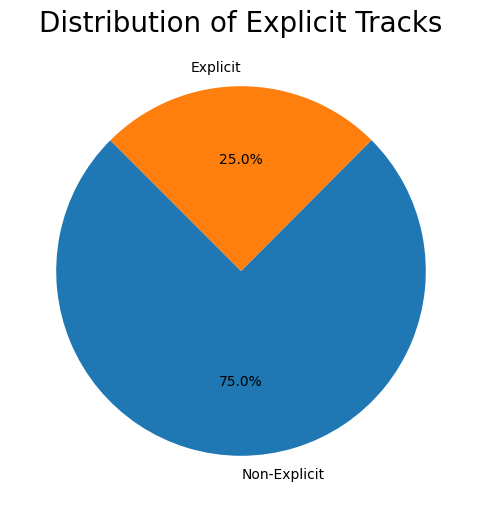

In [207]:
# Pie chart of explicit tracks
plt.figure(figsize=(13, 6))
data = df.explicit.value_counts().tolist()
labels = ['Non-Explicit', 'Explicit']
plt.pie(data, labels=labels, autopct='%1.1f%%', startangle=135)
plt.title("Distribution of Explicit Tracks", fontsize=20)
plt.show()

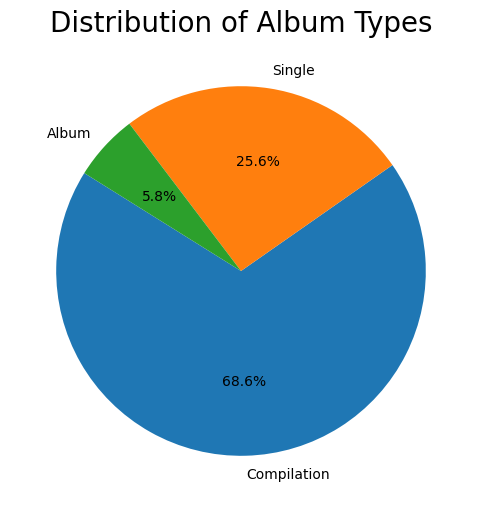

In [208]:
# Pie chart of album types
plt.figure(figsize=(13, 6))
data = df.album_type.value_counts().tolist()
labels = ['Compilation', 'Single', 'Album']
plt.pie(data, labels=labels, autopct='%1.1f%%', startangle=148)
plt.title("Distribution of Album Types", fontsize=20)
plt.show()

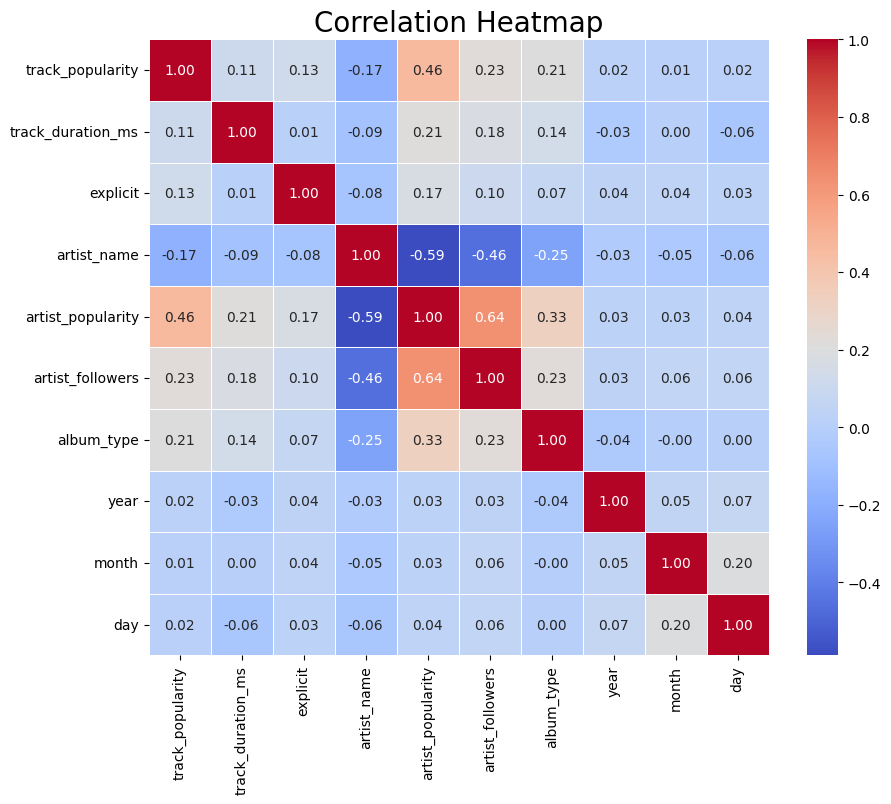

In [209]:
# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", linewidths=0.5,  cmap="coolwarm")
plt.title("Correlation Heatmap", fontsize=20)
plt.show()

---

### 4.5. Outlier Removal
Some values may be too big for our machine learning model to interpret in any way. Hence, these extreme cases will create noise for it that will reduce its performance.

In [210]:
print("Longest track : " + str(max(df["track_duration_ms"])))
print("Median of the tracks' length : " + str(df["track_duration_ms"].median()))

# removing tracks of length greater than 3 minutes
df.drop(df[df["track_duration_ms"] >= 300000].index, inplace=True)

Longest track : 811077
Median of the tracks' length : 207276.0


In [211]:
print("Artist with the least amount of followers : " + str(min(df["artist_followers"])))
print("Median of artists' followers : " + str(df["artist_followers"].median()))

# removing tracks belonging to artists with too few followers
df.drop(df[df["artist_followers"] <= 10000].index, inplace=True)

Artist with the least amount of followers : 0.0
Median of artists' followers : 6132588.0


In [212]:
print("Year with the least amount of tracks released : " + str())
for year in np.sort(df["year"].unique()) : 
    print(str(year) + " number of tracks : " + str(df[df["year"] == year].__len__()))

Year with the least amount of tracks released : 
0000 number of tracks : 2
1952 number of tracks : 1
1958 number of tracks : 1
1959 number of tracks : 5
1960 number of tracks : 1
1962 number of tracks : 5
1963 number of tracks : 1
1964 number of tracks : 1
1965 number of tracks : 3
1966 number of tracks : 8
1967 number of tracks : 10
1968 number of tracks : 1
1969 number of tracks : 16
1970 number of tracks : 6
1971 number of tracks : 5
1972 number of tracks : 3
1973 number of tracks : 10
1974 number of tracks : 1
1975 number of tracks : 4
1976 number of tracks : 5
1977 number of tracks : 9
1978 number of tracks : 7
1979 number of tracks : 5
1980 number of tracks : 9
1981 number of tracks : 5
1982 number of tracks : 3
1983 number of tracks : 4
1984 number of tracks : 7
1985 number of tracks : 6
1986 number of tracks : 9
1987 number of tracks : 28
1988 number of tracks : 5
1989 number of tracks : 6
1990 number of tracks : 5
1991 number of tracks : 79
1992 number of tracks : 13
1993 numb

In [213]:
# it pains me to say so, but let's delete songs from before the 90's
df.drop(df[df["year"].astype(int) <= 1990].index, inplace=True)

---

## 6. Unsupervised learning

Let's first import libraries that will be necessary for making unsupervised learning.<br>
We'll use the K Means clustering method.

In [214]:
from sklearn.cluster import KMeans

### 6.1. Finding the best K value (Elbow method)
For multiple values of K (number of clusters), we'll find their "intertia"(error) and keep the model with a good equilibrium between not too much errors and not too many clusters.

In [215]:
df

,track_popularity,track_duration_ms,explicit,artist_name,artist_popularity,artist_followers,album_type,year,month,day
0,61,213173,0,0,80.0,17755451.0,0,2009,11,09
1,67,158760,0,1,69.0,293734.0,1,2023,01,13
2,63,225328,0,2,100.0,145396321.0,2,2021,04,09
3,72,158463,1,3,90.0,118692183.0,2,2021,07,30
4,57,267013,0,4,90.0,68997177.0,2,2010,01,01
...,...,...,...,...,...,...,...,...,...,...
8772,77,222093,1,1188,70.0,5124117.0,2,2015,09,25
8773,65,209698,0,1366,66.0,786890.0,1,2022,04,29
8775,81,218880,1,158,94.0,113039308.0,2,2016,11,25
8776,84,203600,0,2548,68.0,1188508.0,2,2001,03,21


In [216]:
error = []
k_range = range(1,10)

for k in k_range :
    km = KMeans(n_clusters=k)
    km.fit(df[["track_popularity","track_duration_ms","explicit","artist_name","artist_popularity","artist_followers","album_type","year","month","day"]])
    error.append(km.inertia_)

Text(0.5, 1.0, 'Elbow Diagram of K Means Models for Different Values of K Against Their Error')

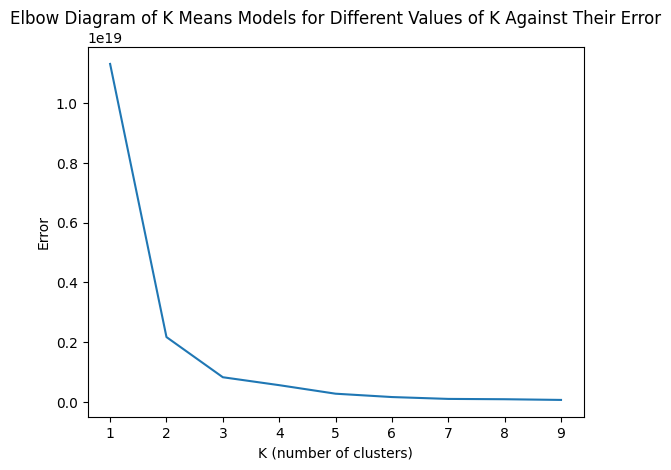

In [217]:
plt.plot(k_range, error)
plt.xlabel("K (number of clusters)")
plt.ylabel("Error")
plt.title("Elbow Diagram of K Means Models for Different Values of K Against Their Error")

We find that the best value for K is 3.

### 6.2. Computing the K Means algorithm with K = 3

In [218]:
KM = KMeans(n_clusters=3)

In [219]:
y_predicted = km.fit_predict(df[["track_popularity","track_duration_ms","explicit","artist_name","artist_popularity","artist_followers","album_type","year","month","day"]])

df["cluster"] = y_predicted

In [220]:
df_cl0 = df[df["cluster"] == 0] # first cluster
df_cl1 = df[df["cluster"] == 1] # second cluster
df_cl2 = df[df["cluster"] == 2] # third cluster

### 6.3. Visualizing the clusters on a cloud point

In order to have a proper visualization of the situation, let's plot each cluster on "track_popularity" against other potential influencers.<br>
Hence, we'll have plots of the axis "track_popularity" with respect to "track_duration_ms", then with respect to "artist_popularity", etc...

Text(0, 0.5, 'artist_followers')

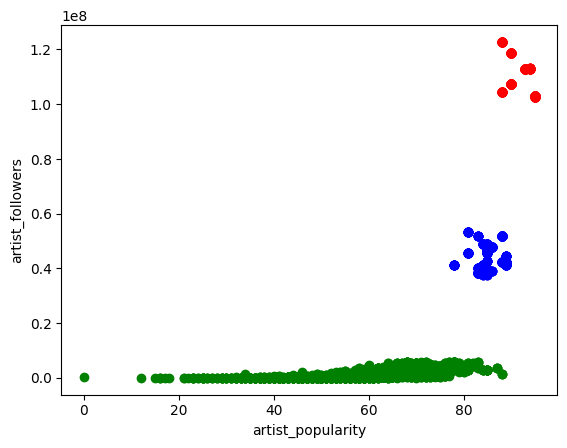

In [221]:
plt.scatter(df_cl0['artist_popularity'],df_cl0['artist_followers'],color='green')
plt.scatter(df_cl1['artist_popularity'],df_cl1['artist_followers'],color='red')
plt.scatter(df_cl2['artist_popularity'],df_cl2['artist_followers'],color='blue')
plt.xlabel('artist_popularity')
plt.ylabel('artist_followers')

# The graph below is a logical example because the more followers an artist has, generally speaking the more popular he is

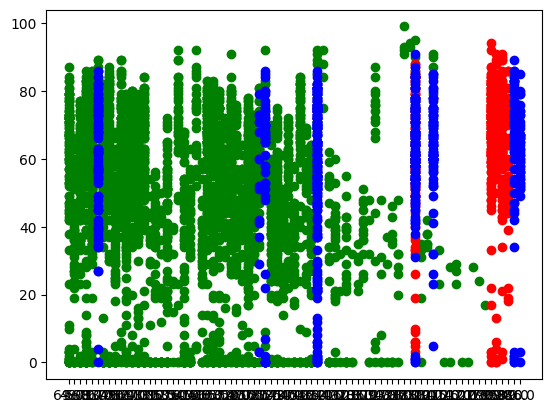

In [222]:
plt.scatter(df_cl0["artist_popularity"].astype(str), df_cl0["track_popularity"], color="green")
plt.scatter(df_cl1["artist_popularity"].astype(str), df_cl1["track_popularity"], color="red")
plt.scatter(df_cl2["artist_popularity"].astype(str), df_cl2["track_popularity"], color="blue")

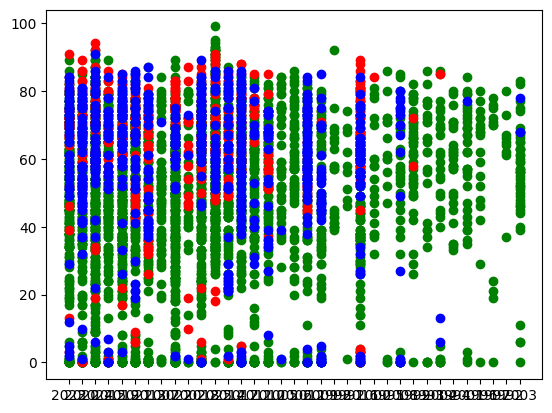

In [223]:
plt.scatter(df_cl0["year"].astype(str), df_cl0["track_popularity"], color="green")
plt.scatter(df_cl1["year"].astype(str), df_cl1["track_popularity"], color="red")
plt.scatter(df_cl2["year"].astype(str), df_cl2["track_popularity"], color="blue")


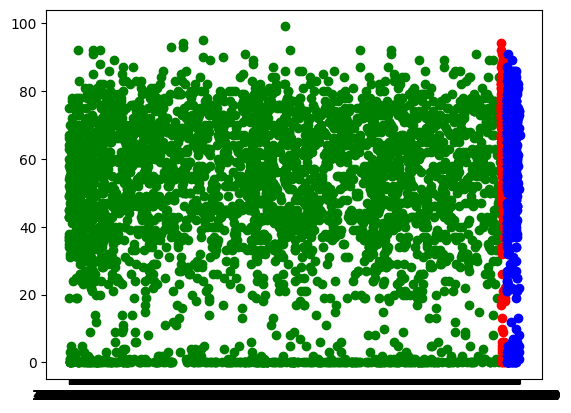

In [224]:
plt.scatter(df_cl0["artist_followers"].astype(str), df_cl0["track_popularity"], color="green")
plt.scatter(df_cl1["artist_followers"].astype(str), df_cl1["track_popularity"], color="red")
plt.scatter(df_cl2["artist_followers"].astype(str), df_cl2["track_popularity"], color="blue")

### Although a bit complicated to decipher, we can understand that generally, we can discern the 3 main groups clearly :
- In Green we have the "General or Average artists" cluster which regroups the most tracks and are not exceptionally popular
- In Blue we have the "Up and coming artists" cluster which contains some recent and popular tracks (mostly after 2012)
- In Red we finally have the "Top artists" cluster which represents the artists that are the most popular out of everyone, most of them are fairlyy recent (2010's) but we can still see one or two major artists from before 2000, these are "Classic" artists who are still really popular even after decades (for example Michael Jackson and other big names of this era)

### Now for Supervised Learning, we will try to predict the cluster and the popularity of a track according to our data

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report

X = df.select_dtypes(include='number').copy()
y_pop = df['track_popularity']
y_cluster = df['cluster']

In [ ]:
# For our Popularity predictions we use KNN Regressor because it is a numerical value prediction

X_train, X_test, y_train, y_test = train_test_split(X, y_pop, test_size=0.2, random_state=42)

knn_reg = KNeighborsRegressor(n_neighbors=5)
knn_reg.fit(X_train, y_train)
y_pred_pop = knn_reg.predict(X_test)

AvgError= mean_squared_error(y_test, y_pred_pop)
r2 = r2_score(y_test, y_pred_pop)

print("The average error is :", AvgError)
print("R² Score:", r2)

In [ ]:
# For our Cluster prediction we use KNN Classification because it's a categorization

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X, y_cluster, test_size=0.2, random_state=42)
knn_cluster = KNeighborsClassifier(n_neighbors=5)
knn_cluster.fit(X_train_c, y_train_c)


y_pred_cl = knn_cluster.predict(X_test_c)
Accuracy = accuracy_score(y_test_c, y_pred_cl)
print("Accuracy:", Accuracy)
print("\nClassification Report:\n", classification_report(y_test_c, y_pred_cl))
# We found that Classification report is a useful method that synthetizes the data efficiently for each cluster